# Introduction

One of the most difficult tasks in computer vision is creating new images from existing ones. The introduction of deep learning techniques made this task feasible, attracting the researcher to create new images. Many other applications, such as object reconstruction, data augmentation, and fugitive recognition, benefit from the creation of new images.

Because of their tremendous progress over the last decade, deep learning-based generative models have gained increasing attention. There are two major families of models that deserve special attention among these: Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

Generative Adversarial Networks (GANs) are a method of generative modeling that employs deep learning methods such as convolutional neural networks. Generative modeling is an unsupervised machine learning task that involves automatically discovering and learning the regularities or patterns in input data so that the model can be used to generate or output new examples that could have been drawn from the original dataset. 

GAN's architecture consists of two components: generator and discriminator. Its generator generates fake images that could fool the discriminator heuristically. Its discriminator attempts to distinguish between real and fake images.


In this notebook, GAN will be used to generate images based on the MNIST dataset. Vanilla GAN, Deeply Convolutional GANs and Least Squares GAN (LSGAN). To evaluate the results, I will use the Fréchet Inception Distance (FID) and Kernel Inception Distance (KID) metrics. 

## Generative Adversarial Networks (GANs)


In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stability and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a6/gan_outputs_pytorch.png)

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from gan import hello_gan
hello_gan()

from a6_helper import hello_helper
hello_helper()

Hello from gan.py!
Hello from a6_helper.py!


In [4]:
pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Load several useful packages that are used in this notebook:

In [80]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from eecs598.grad import rel_error
from eecs598.utils import reset_seed

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [117]:
if torch.cuda.is_available():
  print('Good to go!')
else:

  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


 Now we'll import some helper functions from the `a6_helper.py` where we will get helper functions to view, verify the neural implemented networks, and initialize weights in the `torch.nn` modules we'll write.
 

In [82]:
from a6_helper import show_images, count_params, initialize_weights,show_cifar_images

dtype = torch.float
device = 'cuda'
answers = {}

## Dataset
 We will be working on the CIFAR10 dataset here. The CIFAR-10 dataset contains 60000 32x32 color images organized into 10 classes, each with 6000 images. There are 50,000 training and 10,000 test images.
The dataset is divided into five training batches and one test batch, each of which contains ten thousand images. The test batch contains exactly 1000 images from each class, chosen at random. The remaining images are distributed in random order to the training batches, but some training batches may contain more images from one class than another. The training batches each contain exactly 5000 images from each class.  Torchvision includes many built-in datasets in the torchvision.datasets module, as well as utility classes for creating your own datasets. We will use the PyTorch CIFAR10 wrapper to download and load the CIFAR10 dataset to simplify our code here. More information about the interface can be found in the [documentation]. The data will be saved in the 'CIFAR10_data' folder. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py) for more information about the interface.

In [121]:
batch_size = 128
image_size = 32
NOISE_DIM = 96

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.43, 0.43, 0.43), 
    (0.43, 0.43, 0.43)),
])

dataset = dset.CIFAR10(root='./CIFAR10_data', download=True, transform=T.ToTensor())

loader_train = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3)

Files already downloaded and verified


## Random Noise
The first step is to generate uniform noise from -1 to 1 with shape `[batch_size, noise_dim]`

Implement `sample_noise` and verify all tests pass below

In [122]:
from gan import sample_noise
reset_seed(0)


batch_size = 3
noise_dim = 4

z = sample_noise(batch_size, noise_dim)
assert z.shape == (batch_size, noise_dim)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Discriminator
The architecture is:
 * Fully connected layer with input size 3072 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image. 

Implement `discriminator_cifar` in `gan.py` and test solution by running the cell below. Be sure to use `nn.Sequential` for this model definition and all future models in this notebook.

In [ ]:
from gan import discriminator_cifar

def test_discriminator(true_count=267009):
  model = discriminator_cifar()
  cur_count = count_params(model)
  print(cur_count)    

test_discriminator()

852737


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 3072
 * `TanH` (to clip the image to be in the range of [-1,1])

Implement `generator` in `gan.py` and test your solution by running the cell below.

In [ ]:
from gan import generator_cifar

def test_generator(true_count=1858320):
  model = generator_cifar(4)
  cur_count = count_params(model)
  print(cur_count)


test_generator()

4203520


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above -- instead we will implement the sigmoid as part of the loss function.

**HINTS**: You can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy-with-logits) to compute these losses in a numerically stable manner.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

`true_labels = torch.ones(size, device=device)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

Implement `discriminator_loss` and `generator_loss` in `gan.py` and test solution by running the cell below.. 

In [126]:
from gan import discriminator_loss

answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
  d_loss = discriminator_loss(logits_real, logits_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [127]:
from gan import generator_loss

answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)

def test_generator_loss(logits_fake, g_loss_true):
  g_loss = generator_loss(logits_fake)
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 0


# Optimizing our loss


Next, we'll define a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. We'll use this to construct optimizers for the generators and discriminators for the rest of the notebook in `get_optimizer`.

Implement `get_optimizer` in `gan.py` before moving forward in the notebook

# Training a GAN!
 

In [89]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, save_filename, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=20):
  """
  Train a GAN!
  
  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for  bi, data in tqdm(enumerate(loader_train), total=int(len(dataset)/loader_train.batch_size)):
      
      D_solver.zero_grad()
      image, _ = data
      if len(image) != batch_size:
        continue
      image = image.view(-1,1024*3).to(device)
      #image = image.to(device)
      b_size = len(image)
      real_data = image
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images)

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images)
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu().detach()
        show_cifar_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1
    if epoch == num_epochs - 1:
      show_cifar_images(imgs_numpy[0:16])
      plt.savefig(save_filename)

Now run the cell below to train your first GAN! Last epoch results will be stored in `fc_gan_cifar10_results.jpg`

  0%|          | 0/390 [00:00<?, ?it/s]

Iter: 0, D: 1.403, G:0.6995


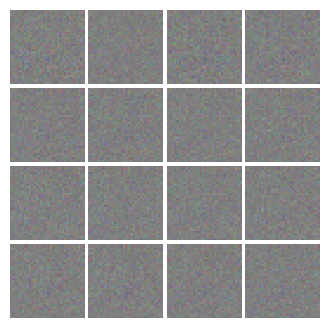

  4%|▍         | 15/390 [00:00<00:07, 46.91it/s]

 62%|██████▏   | 242/390 [00:02<00:01, 114.75it/s]

Iter: 250, D: 0.3909, G:2.618


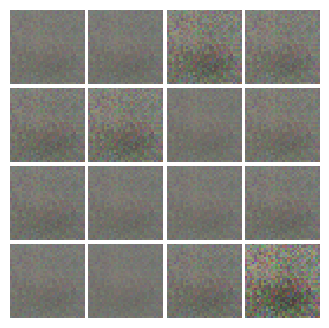

 68%|██████▊   | 265/390 [00:02<00:01, 70.74it/s] 

391it [00:03, 98.40it/s]                          
 28%|██▊       | 109/390 [00:00<00:02, 127.34it/s]

Iter: 500, D: 0.955, G:2.461


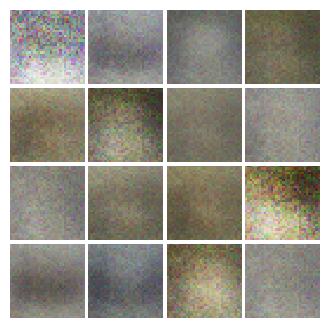

 31%|███▏      | 122/390 [00:01<00:04, 64.95it/s] 

 89%|████████▉ | 349/390 [00:03<00:00, 132.06it/s]

Iter: 750, D: 1.042, G:1.458


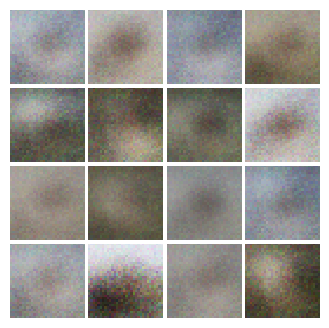

 97%|█████████▋| 377/390 [00:03<00:00, 55.08it/s] 

391it [00:04, 94.74it/s]                         
 53%|█████▎    | 207/390 [00:01<00:01, 135.48it/s]

Iter: 1000, D: 1.36, G:2.995


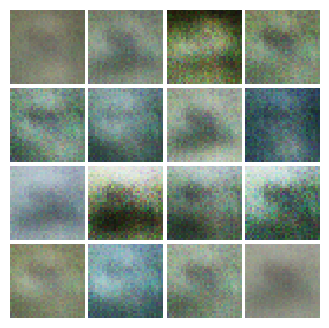

 60%|██████    | 234/390 [00:02<00:01, 82.51it/s] 

391it [00:03, 119.28it/s]                         
 18%|█▊        | 72/390 [00:00<00:02, 138.84it/s]

Iter: 1250, D: 1.353, G:2.113


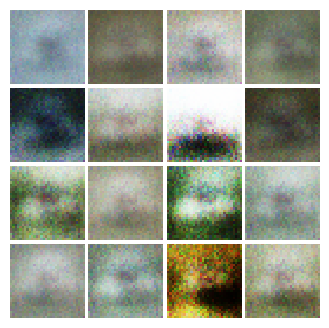

 26%|██▌       | 101/390 [00:01<00:03, 84.62it/s]

 84%|████████▎ | 326/390 [00:02<00:00, 135.03it/s]

Iter: 1500, D: 0.9735, G:1.995


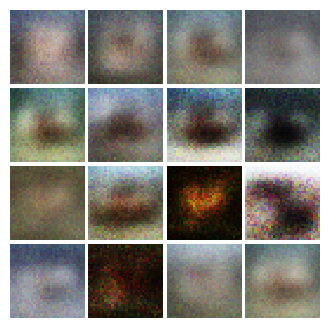

 91%|█████████ | 354/390 [00:03<00:00, 69.34it/s] 

391it [00:03, 106.02it/s]                        
 46%|████▌     | 180/390 [00:01<00:01, 132.72it/s]

Iter: 1750, D: 1.195, G:1.337


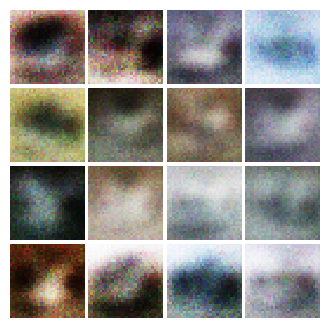

 54%|█████▎    | 209/390 [00:01<00:02, 83.17it/s] 

391it [00:03, 118.23it/s]                         
 11%|█         | 41/390 [00:00<00:02, 129.47it/s]

Iter: 2000, D: 1.211, G:1.224


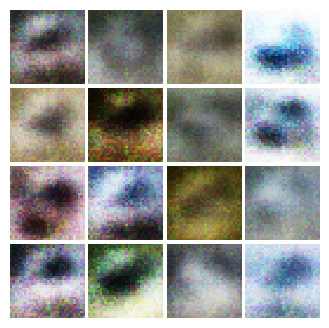

 17%|█▋        | 68/390 [00:00<00:05, 63.25it/s] 

 75%|███████▍  | 292/390 [00:02<00:00, 137.93it/s]

Iter: 2250, D: 1.29, G:1.241


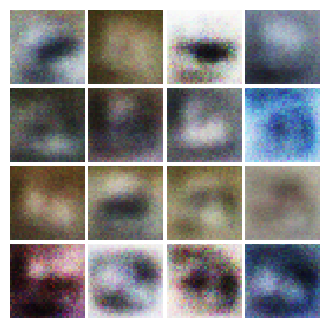

 82%|████████▏ | 321/390 [00:03<00:00, 88.82it/s] 

391it [00:03, 107.21it/s]                         
 39%|███▉      | 153/390 [00:01<00:01, 131.03it/s]

Iter: 2500, D: 1.463, G:1.187


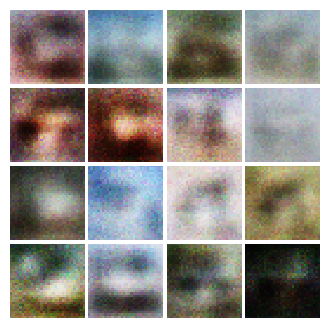

 46%|████▌     | 180/390 [00:01<00:03, 68.02it/s] 

391it [00:03, 114.72it/s]                         
  3%|▎         | 10/390 [00:00<00:03, 97.89it/s]

Iter: 2750, D: 1.061, G:1.393


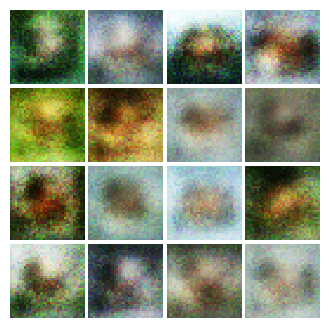

  9%|▉         | 35/390 [00:00<00:05, 63.72it/s]

 68%|██████▊   | 265/390 [00:02<00:00, 136.49it/s]

Iter: 3000, D: 1.236, G:0.982


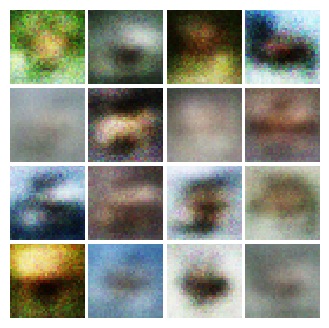

 74%|███████▍  | 290/390 [00:02<00:01, 78.49it/s] 

391it [00:03, 108.83it/s]                         
 31%|███       | 121/390 [00:00<00:02, 130.51it/s]

Iter: 3250, D: 1.234, G:1.116


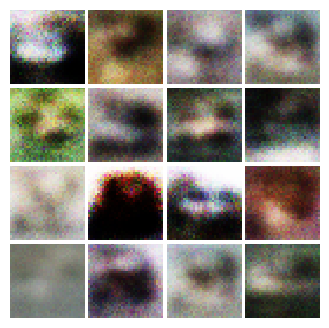

 38%|███▊      | 149/390 [00:01<00:03, 65.64it/s] 

 96%|█████████▌| 373/390 [00:03<00:00, 134.05it/s]

Iter: 3500, D: 1.256, G:0.9841


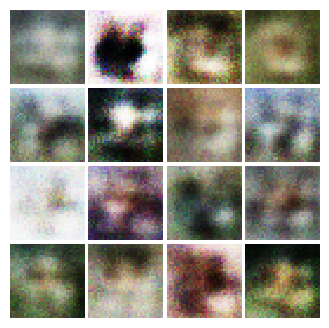

391it [00:03, 102.63it/s]                         


 58%|█████▊    | 227/390 [00:01<00:01, 121.92it/s]

Iter: 3750, D: 1.251, G:0.8344


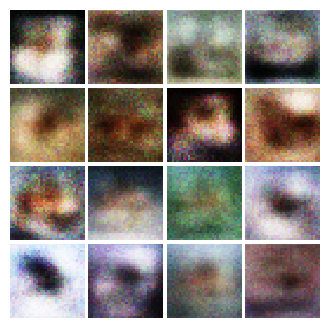

 65%|██████▌   | 255/390 [00:02<00:02, 67.16it/s] 

391it [00:03, 109.92it/s]                         
 25%|██▍       | 96/390 [00:00<00:02, 133.61it/s]

Iter: 4000, D: 1.166, G:0.9579


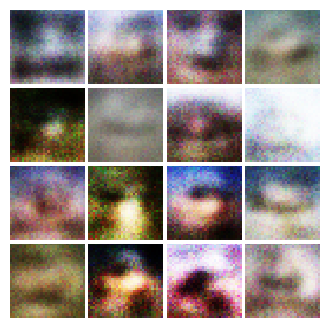

 32%|███▏      | 124/390 [00:01<00:03, 81.51it/s]

 89%|████████▉ | 347/390 [00:02<00:00, 131.98it/s]

Iter: 4250, D: 1.326, G:0.8669


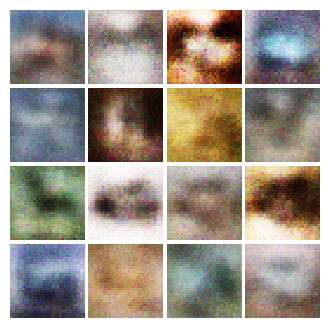

 96%|█████████▌| 375/390 [00:03<00:00, 83.34it/s] 

391it [00:03, 107.61it/s]                        
 54%|█████▎    | 209/390 [00:01<00:01, 136.63it/s]

Iter: 4500, D: 1.375, G:0.988


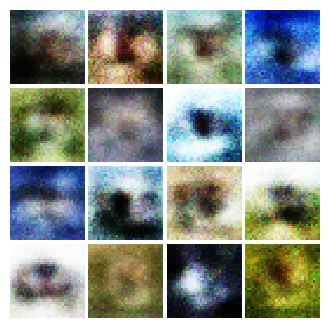

 61%|██████    | 237/390 [00:02<00:02, 68.43it/s] 

391it [00:03, 114.03it/s]                         
 17%|█▋        | 68/390 [00:00<00:02, 130.97it/s]

Iter: 4750, D: 1.433, G:0.9371


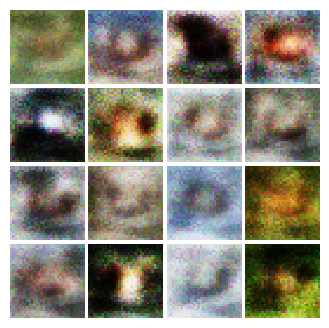

 25%|██▍       | 97/390 [00:01<00:03, 82.25it/s] 

 82%|████████▏ | 320/390 [00:02<00:00, 134.36it/s]

Iter: 5000, D: 1.438, G:0.8448


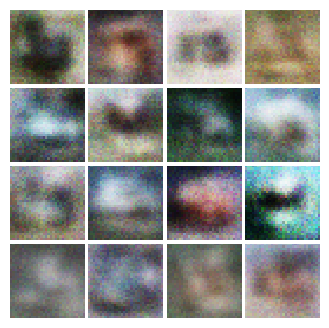

 86%|████████▌ | 334/390 [00:03<00:00, 58.12it/s] 

391it [00:03, 106.92it/s]                         
 43%|████▎     | 167/390 [00:01<00:01, 133.14it/s]

Iter: 5250, D: 1.347, G:0.8366


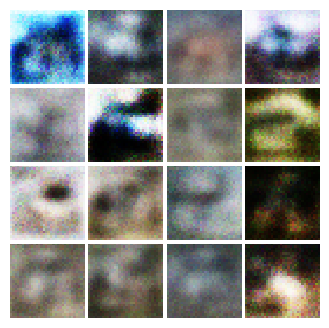

 50%|█████     | 195/390 [00:01<00:02, 82.41it/s] 

391it [00:03, 120.37it/s]                         
  7%|▋         | 26/390 [00:00<00:02, 128.47it/s]

Iter: 5500, D: 1.313, G:0.8628


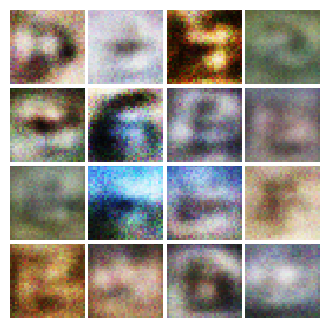

 14%|█▍        | 56/390 [00:00<00:04, 76.57it/s] 

 72%|███████▏  | 281/390 [00:02<00:00, 145.52it/s]

Iter: 5750, D: 1.343, G:0.8664


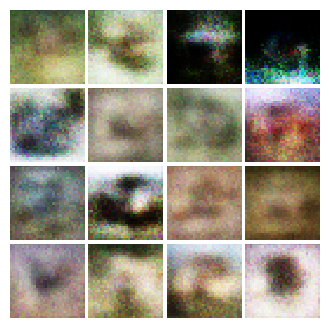

 80%|███████▉  | 311/390 [00:02<00:01, 74.89it/s] 

391it [00:03, 110.13it/s]                         
 37%|███▋      | 143/390 [00:01<00:02, 109.65it/s]

Iter: 6000, D: 1.335, G:0.731


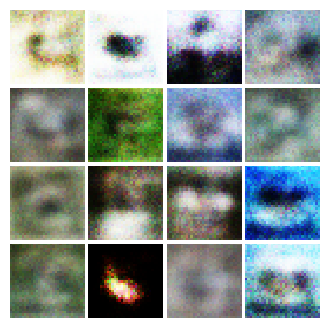

 43%|████▎     | 168/390 [00:01<00:03, 73.09it/s] 

391it [00:03, 112.42it/s]                         
  0%|          | 0/390 [00:00<?, ?it/s]

Iter: 6250, D: 1.373, G:0.7248


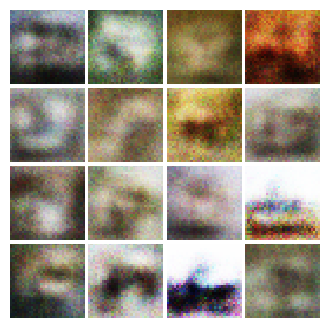

  6%|▋         | 25/390 [00:00<00:08, 42.53it/s]

 64%|██████▍   | 249/390 [00:02<00:01, 132.00it/s]

Iter: 6500, D: 1.33, G:0.769


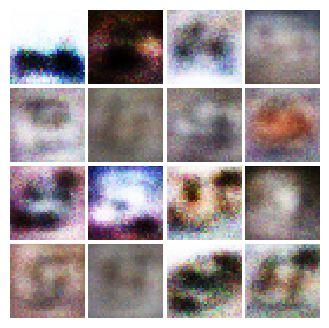

 71%|███████   | 277/390 [00:02<00:01, 84.09it/s] 

391it [00:03, 103.77it/s]                         
 28%|██▊       | 109/390 [00:00<00:02, 131.91it/s]

Iter: 6750, D: 1.417, G:0.7103


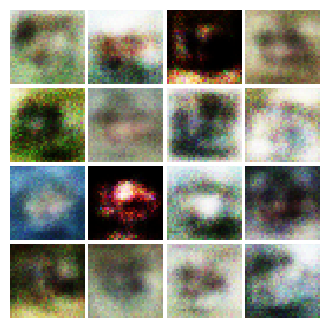

 35%|███▌      | 137/390 [00:01<00:03, 67.10it/s] 

 93%|█████████▎| 361/390 [00:03<00:00, 132.33it/s]

Iter: 7000, D: 1.334, G:0.7106


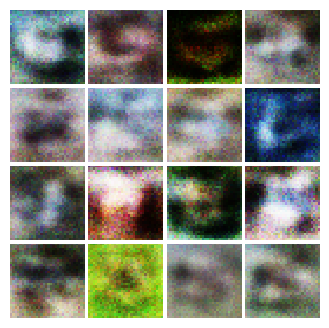

391it [00:03, 104.08it/s]                         


 57%|█████▋    | 222/390 [00:01<00:01, 132.69it/s]

Iter: 7250, D: 1.376, G:0.7925


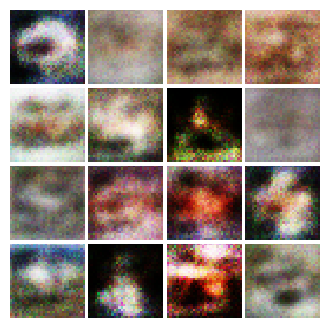

 64%|██████▍   | 250/390 [00:02<00:01, 83.42it/s] 

391it [00:03, 121.22it/s]                         
 21%|██        | 82/390 [00:00<00:02, 132.57it/s]

Iter: 7500, D: 1.42, G:0.7536


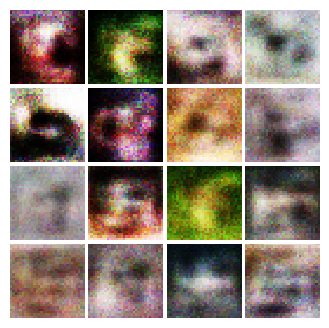

 28%|██▊       | 110/390 [00:01<00:04, 65.81it/s]

 85%|████████▌ | 332/390 [00:02<00:00, 143.85it/s]

Iter: 7750, D: 1.373, G:0.7889


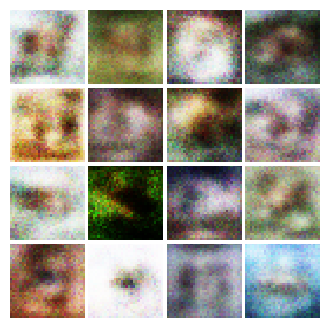

 93%|█████████▎| 362/390 [00:03<00:00, 91.24it/s] 

391it [00:03, 108.26it/s]                         


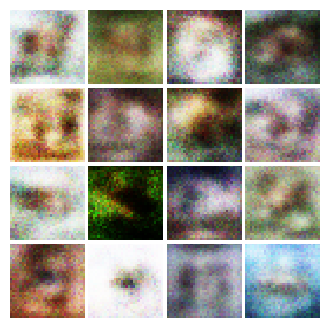

In [90]:
from gan import get_optimizer
reset_seed(0)

D = discriminator_cifar().to(device)
G = generator_cifar().to(device)
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, 'fc_gan_cifar10_results.jpg')

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In these equations, we assume that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Run following cell to verify our implementation

In [128]:
from gan import ls_discriminator_loss
from gan import ls_generator_loss

answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
  d_loss = ls_discriminator_loss(score_real, score_fake)
  g_loss = ls_generator_loss(score_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Run the following cell to train your model! Your last epoch results will be stored in `ls_gan_results.jpg` for you to submit to the autograder

  0%|          | 0/390 [00:00<?, ?it/s]

Iter: 0, D: 0.5085, G:0.4536


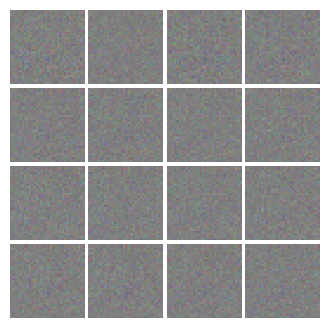

  4%|▍         | 15/390 [00:00<00:08, 43.98it/s]

 62%|██████▏   | 241/390 [00:02<00:01, 136.01it/s]

Iter: 250, D: 0.07135, G:0.474


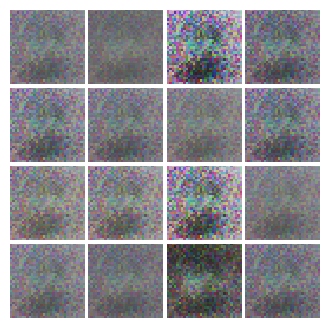

 69%|██████▉   | 269/390 [00:02<00:01, 85.11it/s] 

391it [00:03, 110.94it/s]                         
 26%|██▌       | 100/390 [00:00<00:02, 138.83it/s]

Iter: 500, D: 0.2754, G:0.471


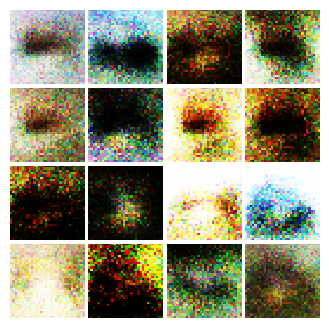

 33%|███▎      | 129/390 [00:01<00:03, 69.15it/s] 

 91%|█████████ | 353/390 [00:02<00:00, 142.11it/s]

Iter: 750, D: 0.1926, G:0.3192


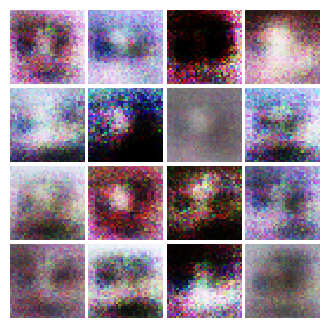

 98%|█████████▊| 383/390 [00:03<00:00, 90.07it/s] 

391it [00:03, 109.19it/s]                        
 53%|█████▎    | 208/390 [00:01<00:01, 136.80it/s]

Iter: 1000, D: 0.1814, G:0.2919


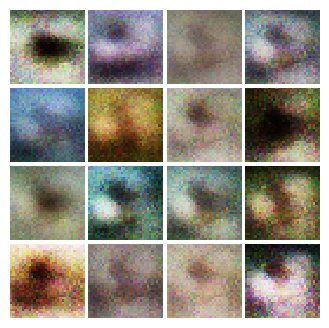

 61%|██████    | 236/390 [00:02<00:02, 70.12it/s] 

391it [00:03, 115.51it/s]                         
 18%|█▊        | 71/390 [00:00<00:02, 141.39it/s]

Iter: 1250, D: 0.24, G:0.2137


 26%|██▌       | 100/390 [00:01<00:03, 83.81it/s]

 82%|████████▏ | 320/390 [00:02<00:00, 140.73it/s]

Iter: 1500, D: 0.204, G:0.2277


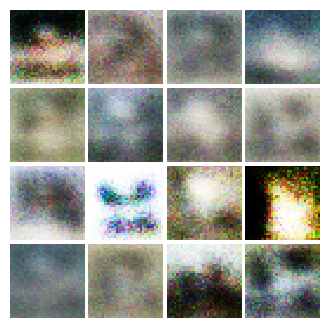

 89%|████████▉ | 349/390 [00:03<00:00, 73.33it/s] 

391it [00:03, 108.57it/s]                        
 46%|████▌     | 180/390 [00:01<00:01, 136.68it/s]

Iter: 1750, D: 0.2422, G:0.1893


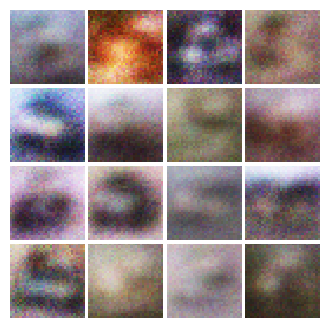

 53%|█████▎    | 208/390 [00:01<00:02, 84.33it/s] 

391it [00:03, 122.19it/s]                         
 10%|█         | 40/390 [00:00<00:02, 132.90it/s]

Iter: 2000, D: 0.2659, G:0.1696


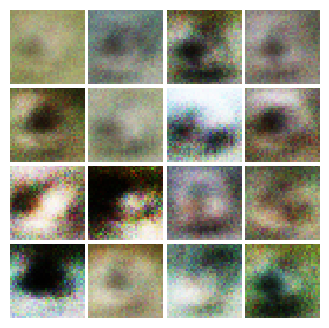

 17%|█▋        | 68/390 [00:00<00:04, 77.59it/s] 

 75%|███████▍  | 292/390 [00:02<00:00, 136.79it/s]

Iter: 2250, D: 0.2719, G:0.1854


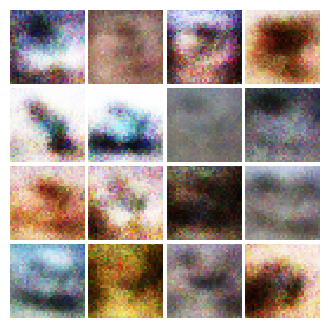

 82%|████████▏ | 320/390 [00:03<00:01, 69.87it/s] 

391it [00:03, 106.13it/s]                         
 38%|███▊      | 147/390 [00:01<00:01, 139.51it/s]

Iter: 2500, D: 0.2353, G:0.1793


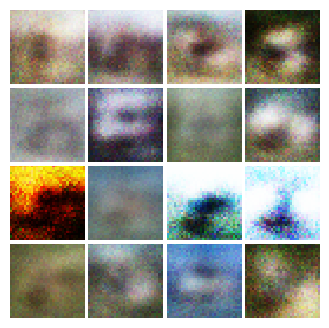

 45%|████▍     | 175/390 [00:01<00:02, 86.06it/s] 

391it [00:03, 124.04it/s]                         
  3%|▎         | 13/390 [00:00<00:03, 122.71it/s]

Iter: 2750, D: 0.2201, G:0.1957


 10%|█         | 40/390 [00:00<00:06, 54.01it/s] 

 69%|██████▉   | 270/390 [00:02<00:00, 144.57it/s]

Iter: 3000, D: 0.2353, G:0.2272


 77%|███████▋  | 300/390 [00:02<00:00, 90.71it/s] 

391it [00:03, 109.03it/s]                         
 32%|███▏      | 123/390 [00:00<00:01, 135.84it/s]

Iter: 3250, D: 0.2483, G:0.1583


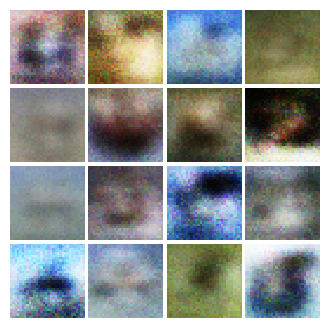

 39%|███▉      | 152/390 [00:01<00:02, 86.49it/s] 

 96%|█████████▌| 373/390 [00:02<00:00, 140.86it/s]

Iter: 3500, D: 0.2408, G:0.1549


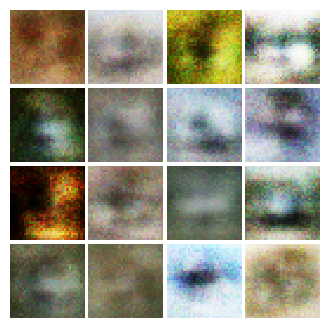

391it [00:03, 107.74it/s]                         


 61%|██████    | 238/390 [00:01<00:01, 137.97it/s]

Iter: 3750, D: 0.2382, G:0.1504


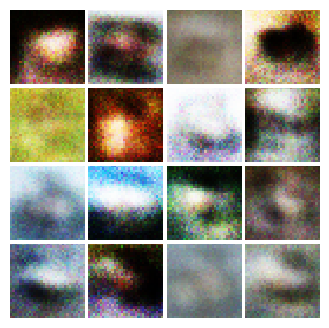

 68%|██████▊   | 267/390 [00:02<00:01, 86.65it/s] 

391it [00:03, 122.45it/s]                         
 24%|██▍       | 94/390 [00:00<00:02, 134.79it/s]

Iter: 4000, D: 0.2556, G:0.1389


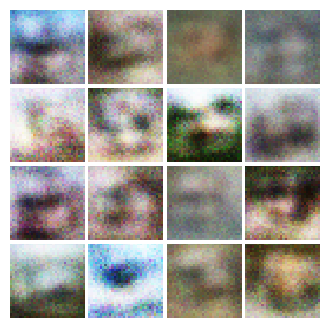

 31%|███▏      | 122/390 [00:01<00:03, 67.14it/s]

 89%|████████▉ | 347/390 [00:03<00:00, 135.27it/s]

Iter: 4250, D: 0.2382, G:0.1538


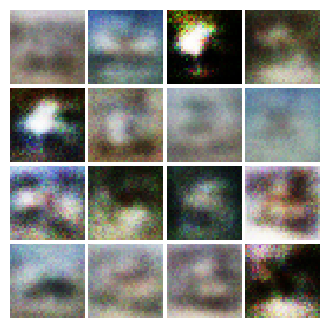

 96%|█████████▌| 375/390 [00:03<00:00, 85.37it/s] 

391it [00:03, 105.33it/s]                        
 53%|█████▎    | 206/390 [00:01<00:01, 139.04it/s]

Iter: 4500, D: 0.2453, G:0.1467


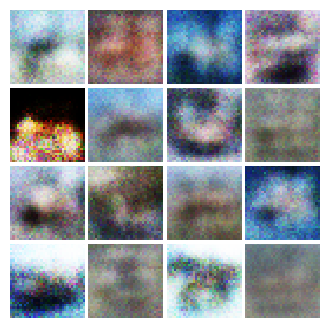

 60%|██████    | 235/390 [00:01<00:01, 86.93it/s] 

391it [00:03, 123.39it/s]                         
 17%|█▋        | 68/390 [00:00<00:02, 136.93it/s]

Iter: 4750, D: 0.2421, G:0.1617


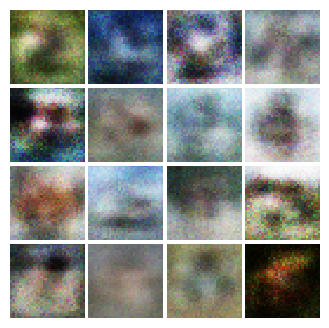

 25%|██▍       | 97/390 [00:01<00:04, 68.27it/s] 

 79%|███████▊  | 307/390 [00:02<00:00, 138.62it/s]

Iter: 5000, D: 0.2467, G:0.147


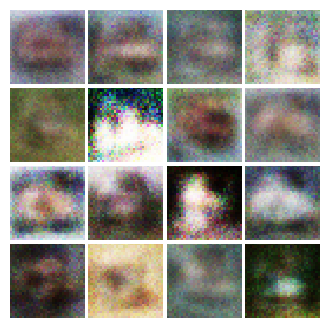

 86%|████████▌ | 335/390 [00:03<00:00, 87.90it/s] 

391it [00:03, 109.23it/s]                         
 45%|████▌     | 177/390 [00:01<00:01, 145.69it/s]

Iter: 5250, D: 0.222, G:0.1451


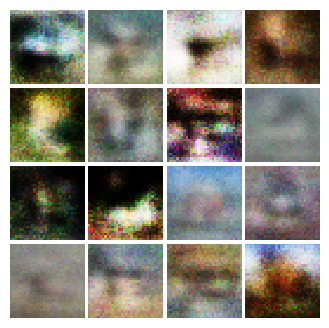

 53%|█████▎    | 207/390 [00:01<00:02, 75.35it/s] 

391it [00:03, 119.53it/s]                         
  7%|▋         | 27/390 [00:00<00:02, 128.93it/s]

Iter: 5500, D: 0.2549, G:0.1566


 14%|█▍        | 55/390 [00:00<00:04, 73.43it/s] 

 73%|███████▎  | 285/390 [00:02<00:00, 141.23it/s]

Iter: 5750, D: 0.2457, G:0.136


 81%|████████  | 314/390 [00:03<00:01, 72.85it/s] 

391it [00:03, 104.90it/s]                         
 35%|███▌      | 137/390 [00:01<00:01, 134.65it/s]

Iter: 6000, D: 0.2606, G:0.1416


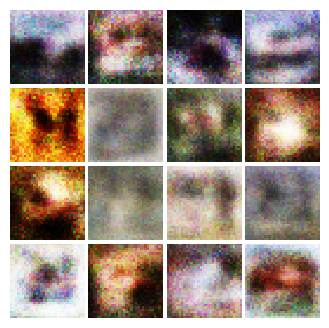

 42%|████▏     | 165/390 [00:01<00:02, 82.68it/s] 

391it [00:03, 119.77it/s]                         
  0%|          | 0/390 [00:00<?, ?it/s]

Iter: 6250, D: 0.2399, G:0.1401


  6%|▋         | 25/390 [00:00<00:06, 55.38it/s]

 64%|██████▍   | 249/390 [00:02<00:00, 147.31it/s]

Iter: 6500, D: 0.2532, G:0.149


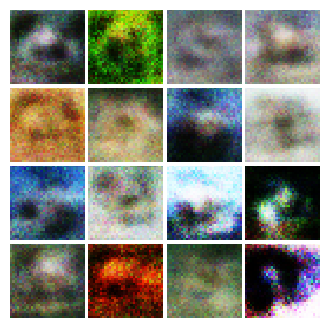

 72%|███████▏  | 279/390 [00:02<00:01, 74.26it/s] 

391it [00:03, 109.44it/s]                         
 28%|██▊       | 109/390 [00:00<00:02, 134.08it/s]

Iter: 6750, D: 0.2499, G:0.1376


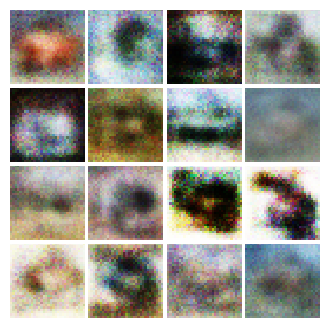

 35%|███▌      | 137/390 [00:01<00:03, 82.97it/s] 

 94%|█████████▎| 365/390 [00:02<00:00, 142.63it/s]

Iter: 7000, D: 0.2689, G:0.1367


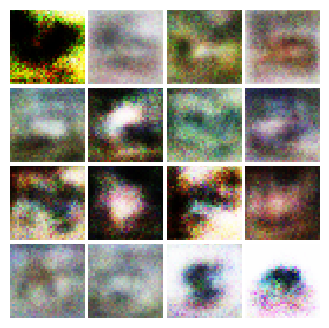

391it [00:03, 107.41it/s]                         


 56%|█████▌    | 219/390 [00:01<00:01, 134.54it/s]

Iter: 7250, D: 0.2444, G:0.1236


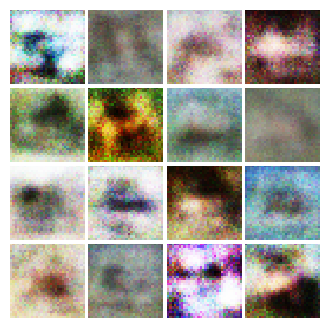

 63%|██████▎   | 247/390 [00:02<00:01, 83.98it/s] 

391it [00:03, 119.60it/s]                         
 21%|██        | 82/390 [00:00<00:02, 132.70it/s]

Iter: 7500, D: 0.234, G:0.1289


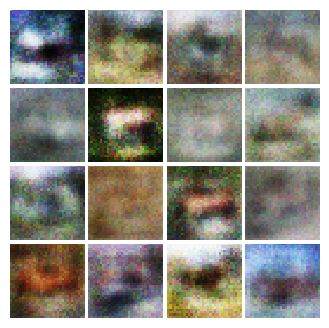

 28%|██▊       | 111/390 [00:01<00:03, 84.51it/s]

 85%|████████▍ | 330/390 [00:02<00:00, 138.47it/s]

Iter: 7750, D: 0.2507, G:0.1316


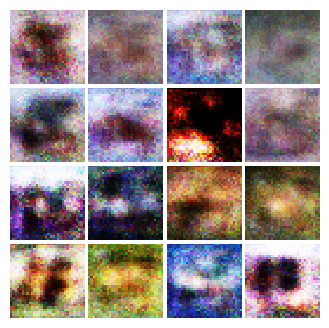

 92%|█████████▏| 358/390 [00:03<00:00, 71.00it/s] 

391it [00:03, 106.71it/s]                        


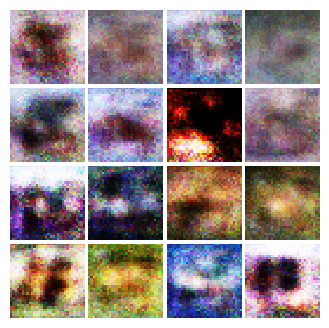

In [92]:
reset_seed(0)

D_LS = discriminator_cifar().to(device)
G_LS = generator_cifar().to(device)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, 'ls_gan_cifar_results.jpg')

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks.

#### Discriminator Architecture

* Reshape into image tensor 
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [59]:
from gan import build_dc_classifier_cifar

data = next(enumerate(loader_train))[-1][0].to(dtype=dtype, device=device)
batch_size = data.size(0)
b = build_dc_classifier_cifar().to(device)
data = data.view(-1, 1024*3)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [93]:
def test_dc_classifer(true_count=1102721):
  model = build_dc_classifier_cifar()
  cur_count = count_params(model)
  print(cur_count)

test_dc_classifer()

1694145


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper] and change it for CIFAR10 
(https://arxiv.org/pdf/1606.03657.pdf). 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Reshape into Image Tensor of shape 7 x 7 x 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 32 x 32 x 3 image, reshape back into 3072 vector

In [96]:
from gan import build_dc_generator_cifar

test_g_gan = build_dc_generator_cifar().to(device)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, dtype=dtype, device=device)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([3, 3072])

Check the number of parameters in your generator as a sanity check:

In [97]:
def test_dc_generator(true_count=6580801):
  model = build_dc_generator_cifar(4)
  cur_count = count_params(model)
  print(cur_count)

test_dc_generator()

8554691


Now, let's train our DC-GAN! Your last epoch results will be stored in `dc_gan_cifar_results.jpg` for you to submit to the autograder

  0%|          | 0/390 [00:00<?, ?it/s]

Iter: 0, D: 1.425, G:4.361


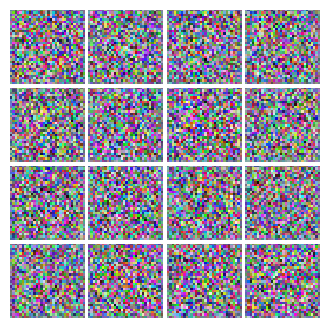

  2%|▏         | 9/390 [00:00<00:20, 18.93it/s]

 64%|██████▍   | 249/390 [00:03<00:01, 78.18it/s]

Iter: 250, D: 1.296, G:0.801


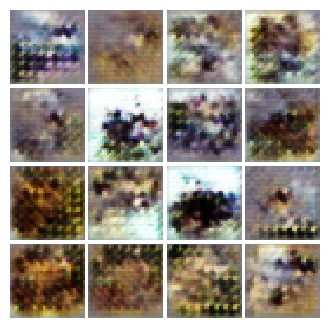

 68%|██████▊   | 265/390 [00:04<00:02, 49.59it/s]

391it [00:05, 66.65it/s]                         
 26%|██▋       | 103/390 [00:01<00:03, 75.03it/s]

Iter: 500, D: 1.405, G:0.9598


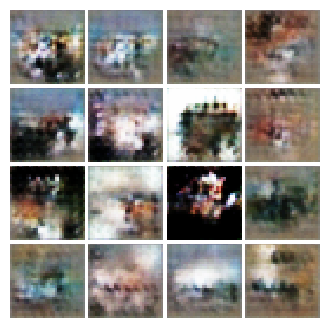

 31%|███       | 119/390 [00:02<00:07, 36.84it/s]

 92%|█████████▏| 359/390 [00:05<00:00, 76.55it/s]

Iter: 750, D: 1.224, G:0.8248


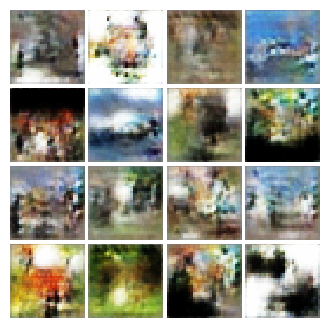

 96%|█████████▌| 375/390 [00:05<00:00, 48.20it/s]

391it [00:06, 64.71it/s]                         
 56%|█████▌    | 219/390 [00:02<00:02, 79.26it/s]

Iter: 1000, D: 1.316, G:0.7829


 61%|██████    | 236/390 [00:03<00:03, 50.20it/s]

391it [00:05, 73.37it/s]                         
 20%|██        | 79/390 [00:01<00:04, 76.10it/s]

Iter: 1250, D: 1.23, G:0.7988


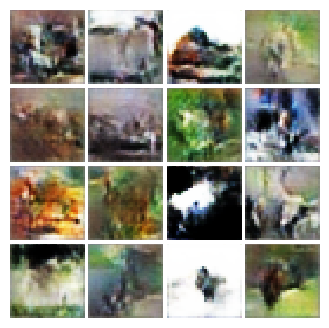

 24%|██▍       | 95/390 [00:01<00:07, 37.91it/s]

 83%|████████▎ | 322/390 [00:04<00:00, 79.65it/s]

Iter: 1500, D: 1.947, G:1.493


 87%|████████▋ | 339/390 [00:05<00:01, 50.78it/s]

391it [00:05, 66.55it/s]                         
 49%|████▊     | 190/390 [00:02<00:02, 77.18it/s]

Iter: 1750, D: 1.177, G:0.7993


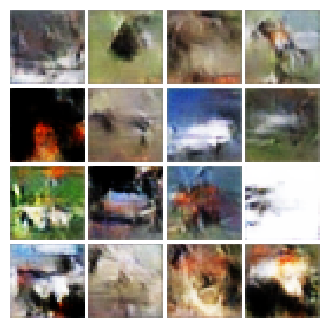

 53%|█████▎    | 206/390 [00:03<00:04, 40.29it/s]

391it [00:05, 70.26it/s]                         
 11%|█         | 43/390 [00:00<00:04, 79.35it/s]

Iter: 2000, D: 0.987, G:1.214


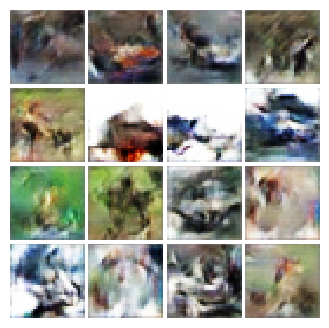

 15%|█▌        | 59/390 [00:01<00:06, 47.91it/s]

 76%|███████▌  | 296/390 [00:04<00:01, 78.06it/s]

Iter: 2250, D: 0.9188, G:1.007


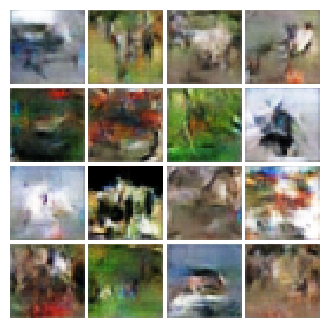

 80%|████████  | 312/390 [00:04<00:01, 47.97it/s]

391it [00:05, 69.81it/s]                         
 40%|████      | 157/390 [00:01<00:02, 79.17it/s]

Iter: 2500, D: 0.8143, G:1.721


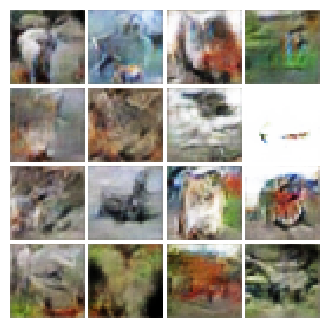

 44%|████▍     | 173/390 [00:02<00:05, 40.80it/s]

391it [00:05, 70.60it/s]                         
  4%|▍         | 15/390 [00:00<00:05, 72.37it/s]

Iter: 2750, D: 0.6703, G:1.38


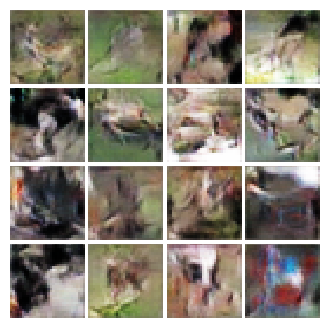

  8%|▊         | 31/390 [00:00<00:08, 42.38it/s]

 69%|██████▉   | 270/390 [00:03<00:01, 80.27it/s]

Iter: 3000, D: 1.277, G:1.316


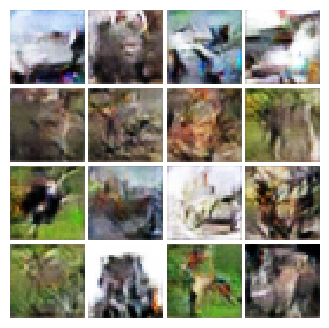

 72%|███████▏  | 279/390 [00:04<00:03, 36.80it/s]

391it [00:05, 68.84it/s]                         
 33%|███▎      | 128/390 [00:01<00:03, 78.25it/s]

Iter: 3250, D: 0.8397, G:1.34


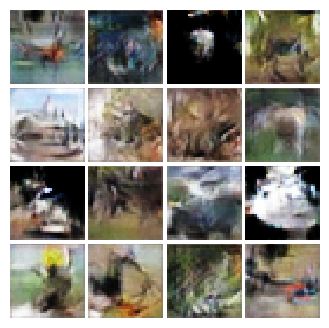

 37%|███▋      | 145/390 [00:02<00:04, 50.16it/s]

 97%|█████████▋| 378/390 [00:05<00:00, 79.46it/s]

Iter: 3500, D: 0.6979, G:1.879


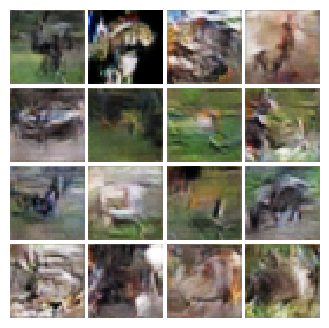

391it [00:05, 67.32it/s]                         


 59%|█████▉    | 232/390 [00:03<00:02, 77.47it/s]

Iter: 3750, D: 0.4779, G:1.996


 64%|██████▍   | 250/390 [00:03<00:02, 50.60it/s]

391it [00:05, 73.28it/s]                         


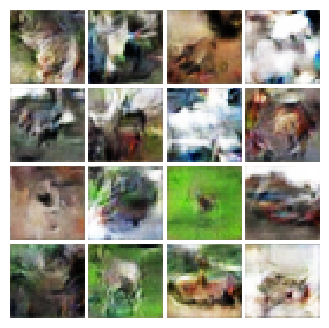

In [98]:
reset_seed(0)

D_DC = build_dc_classifier_cifar().to(device) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator_cifar().to(device)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, 'dc_gan_cifar_results.jpg', num_epochs=10)

#### Latent Space Interpolation
As with our VAE, our final test of our trained GAN model is interpolation in latent space. To create an image, we generate random latent vectors $z 0$ and $z 1$ and linearly interpolate between them. In the figure below, each row interpolates between two random vectors. The model should have smooth transitions along each row for the most part, indicating that it has learned something significant about the underlying spatial structure of the digits it is modeling.

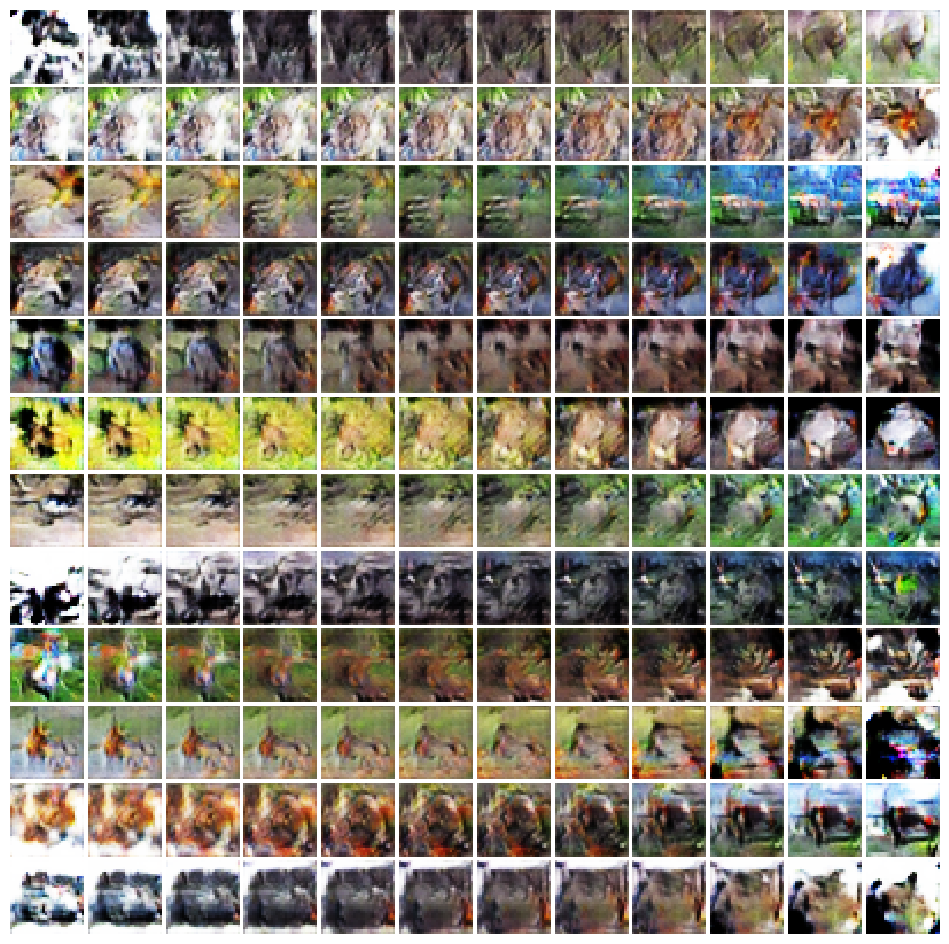

In [99]:
S = 12
z0 = sample_noise(S, NOISE_DIM, device=device)
z1 = sample_noise(S, NOISE_DIM, device=device)
w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, NOISE_DIM)

x = G_DC(z)
show_cifar_images(x.data.cpu())

## Frechet Inception Distance

FID is a performance metric that computes the difference between the feature vectors of real and fake images (Generated by the generator). The lower the FID score, the higher the quality of the images generated by the generator is and the more similar they are to real ones. The feature vectors of images are used in FID.

In [130]:

from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg



class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        self.mixed_7c_output = output

    def forward(self, x):
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]
        self.inception_network(x)
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


def get_activations(images, batch_size):
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)
    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)
        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def preprocess_image(im):
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)
    return im


def preprocess_images(images, use_multiprocessing):
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images


def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid


def load_images(path):
    image_paths = []
    image_extensions = ["png", "jpg"]
    for ext in image_extensions:
        print("Looking for images in", os.path.join(path, "*.{}".format(ext)))
        for impath in glob.glob(os.path.join(path, "*.{}".format(ext))):
            image_paths.append(impath)
    first_image = cv2.imread(image_paths[0])
    W, H = first_image.shape[:2]
    image_paths.sort()
    image_paths = image_paths
    final_images = np.zeros((len(image_paths), H, W, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        final_images[idx] = im
    return final_images




In [141]:
from optparse import OptionParser
    
parser = OptionParser()
parser.add_option("--p1", "--path1", dest="path1", 
                       help="dc_gan_cifar_results")
parser.add_option("--p2", "--path2", dest="path2", 
                       help="dc_gan_results")
parser.add_option("--multiprocessing", dest="use_multiprocessing",
                      help="Toggle use of multiprocessing for image pre-processing. Defaults to use all cores",
                      default=False,
                      action="store_true")
parser.add_option("-b", "--batch-size", dest="batch_size",
                      help="Set batch size to use for InceptionV3 network",
                      type=int)
    
options, _ = parser.parse_args()
assert options.path1 is not None, "--path1 is an required option"
assert options.path2 is not None, "--path2 is an required option"
assert options.batch_size is not None, "--batch_size is an required option"
images1 = load_images(options.path1)
images2 = load_images(options.path2)
fid_value = calculate_fid(images1, images2, options.use_multiprocessing, options.batch_size)
print(fid_value)

<Option at 0x14fb10fd3220: -b/--batch-size>

## Kernel inception distance

For measuring image generation quality, the Kernel Inception Distance (KID) metric was proposed as a replacement for the popular Frechet Inception Distance (FID). Both metrics assess the difference in the representation space generated and training distributions of an InceptionV3 network pretrained on ImageNet.

According to the paper, KID was proposed because FID lacks an unbiased estimator and its expected value is higher when measured on fewer images. KID is better suited to small datasets because its expected value is independent of the number of samples measured. In my experience, it is also computationally lighter, numerically more stable, and easier to implement because it can be estimated on a per-batch basis.